In [18]:
!pip install ace_tools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import pandas as pd
import torch
import sys
import os
# Add parent directory to path
project_root = os.path.abspath("..")
sys.path.append(project_root)
from model import CNN_LSTM, PretrainedCNNLSTM
# Initialize model
model = PretrainedCNNLSTM()

# Create a list to store layer details
layer_details = []

# Extract layer-wise details
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_details.append([name, list(param.shape), param.numel()])

# Create DataFrame
df = pd.DataFrame(layer_details, columns=["Layer Type", "Output Shape", "No. of Parameters"])

df


,Layer Type,Output Shape,No. of Parameters
0,gru.weight_ih_l0,"[384, 512]",196608
1,gru.weight_hh_l0,"[384, 128]",49152
2,gru.bias_ih_l0,[384],384
3,gru.bias_hh_l0,[384],384
4,classifier.0.weight,"[64, 128]",8192
5,classifier.0.bias,[64],64
6,classifier.2.weight,"[61, 64]",3904
7,classifier.2.bias,[61],61


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from model import CNN_LSTM


def model_summary(model, input_shapes):
    """
    Custom model summary function for a PyTorch model with multiple inputs.
    
    Args:
        model (nn.Module): The PyTorch model.
        input_shapes (tuple): A tuple of shapes for each input tensor.
    
    Returns:
        Prints a table with layer-wise details including descriptions.
    """
    summary = OrderedDict()
    
    # Generate dummy inputs based on provided shapes
    inputs = [torch.randn(1, *shape) for shape in input_shapes]

    def register_hook(module):
        """
        Registers a hook to capture layer information, but ignores the top-level model itself.
        """
        def hook(module, input, output):
            # Skip top-level module (the whole CNN_LSTM model itself)
            if isinstance(module, type(model)):  
                return  
            
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary) + 1
            m_key = f"{module_idx} - {class_name}"
            
            # Extract shape if output is a tuple (for LSTM)
            if isinstance(output, tuple):
                output = output[0]

            # Get layer-specific descriptions
            description = get_layer_description(module)

            summary[m_key] = {
                "description": description,
                "output_shape": list(output.shape),
                "params": sum(p.numel() for p in module.parameters() if p.requires_grad),
            }
        
        # Register only child modules, ignore top-level model
        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and module is not model:
            hooks.append(module.register_forward_hook(hook))

    def get_layer_description(layer):
        """Returns a human-readable description for each layer."""
        if isinstance(layer, nn.Conv2d):
            return f"{layer.out_channels} filters, {layer.kernel_size} kernel, stride={layer.stride}, padding={layer.padding}"
        elif isinstance(layer, nn.MaxPool2d):
            return f"Pool size {layer.kernel_size}, stride={layer.stride}"
        elif isinstance(layer, nn.BatchNorm2d):
            return f"BatchNorm for {layer.num_features} channels"
        elif isinstance(layer, nn.Dropout):
            return f"Dropout rate {layer.p}"
        elif isinstance(layer, nn.LSTM):
            return f"{layer.hidden_size} units, {layer.num_layers} layers"
        elif isinstance(layer, nn.Linear):
            return f"{layer.in_features} → {layer.out_features} neurons"
        else:
            return "N/A"

    # Register hooks on all model layers
    hooks = []
    model.apply(register_hook)
    
    # Perform forward pass to trigger hooks
    model(*inputs)
    
    # Remove hooks
    for h in hooks:
        h.remove()

    # Print the summary table
    print("{:<25} {:<50} {:<30} {:<15}".format("Layer", "Description", "Output Shape", "Param #"))
    print("=" * 130)
    total_params = 0
    for layer, info in summary.items():
        total_params += info["params"]
        print("{:<25} {:<50} {:<30} {:<15}".format(layer, info["description"], str(info["output_shape"]), info["params"]))
    
    print("=" * 130)
    print(f"Total Trainable Parameters: {total_params:,}")
    print("=" * 130)

# Example usage
model = PretrainedCNNLSTM()
model_summary(model, [(1, 1849, 1458), (1, 1849, 1458), (1, 1849, 1458)])  # (seq_len, channels, height, width)


Layer                     Description                                        Output Shape                   Param #        
1 - Conv2d                64 filters, (7, 7) kernel, stride=(2, 2), padding=(3, 3) [1, 64, 925, 729]              0              
2 - BatchNorm2d           BatchNorm for 64 channels                          [1, 64, 925, 729]              0              
3 - ReLU                  N/A                                                [1, 64, 925, 729]              0              
4 - MaxPool2d             Pool size 3, stride=2                              [1, 64, 463, 365]              0              
5 - Conv2d                64 filters, (3, 3) kernel, stride=(1, 1), padding=(1, 1) [1, 64, 463, 365]              0              
6 - BatchNorm2d           BatchNorm for 64 channels                          [1, 64, 463, 365]              0              
7 - ReLU                  N/A                                                [1, 64, 463, 365]              0           

![Screenshot 2025-02-07 161135.png](<attachment:Screenshot 2025-02-07 161135.png>)



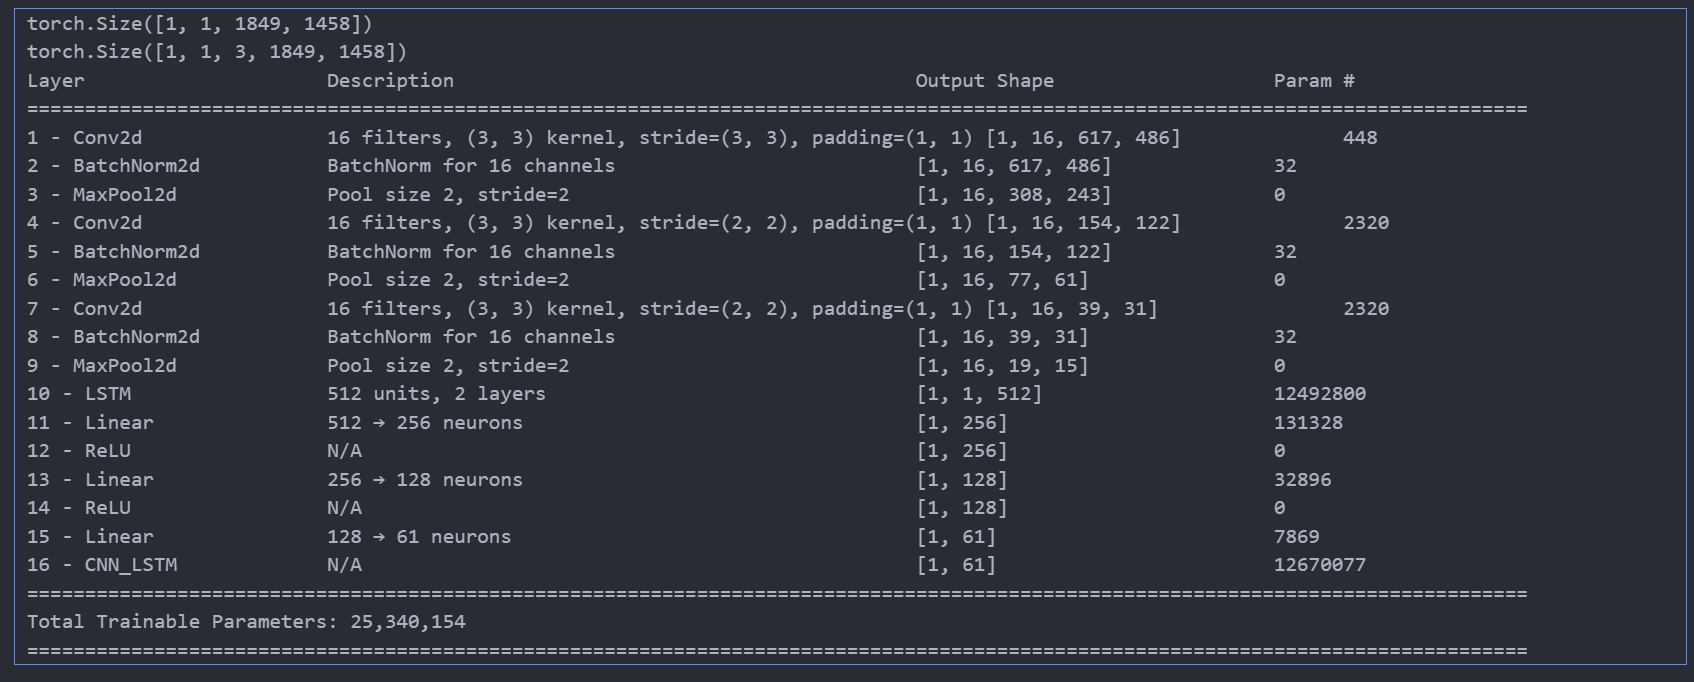

# Data

In [ ]:
from data_loader import HDF5Dataset
import yaml
def load_yaml_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    
    

config = load_yaml_config('config/config.yaml')
variables_to_load = ['ppt', 'tmin', 'tmax']
dataset = HDF5Dataset(config['h5_file'], variables_to_load, config['labels_path'], 2000, 2009)

dataset

In [2]:
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)
loader

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_label_distributions(dataloader, num_labels):
    label_data = {f'Label {i}': [] for i in range(num_labels)}  # Dictionary to store label data by index

    # Collect data
    for data in dataloader:
        labels = data['label'].cpu().numpy()  # Convert labels to numpy array
        for i in range(num_labels):
            label_data[f'Label {i}'].extend(labels[:, i])  # Append label data by index

    # Plot boxplots without outliers
    plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization
    sns.boxplot(data=[label_data[f'Label {i}'] for i in range(num_labels)], showfliers=False)
    
    # Formatting
    plt.xticks(ticks=range(num_labels), labels=[f'Label {i}' for i in range(num_labels)], rotation=90)  # Rotate labels for readability
    plt.title('Boxplots of Labels (Outliers Removed)')
    plt.xlabel('Labels')
    plt.ylabel('Values')
    plt.grid(True)
    
    plt.show()  # Display the boxplot

   


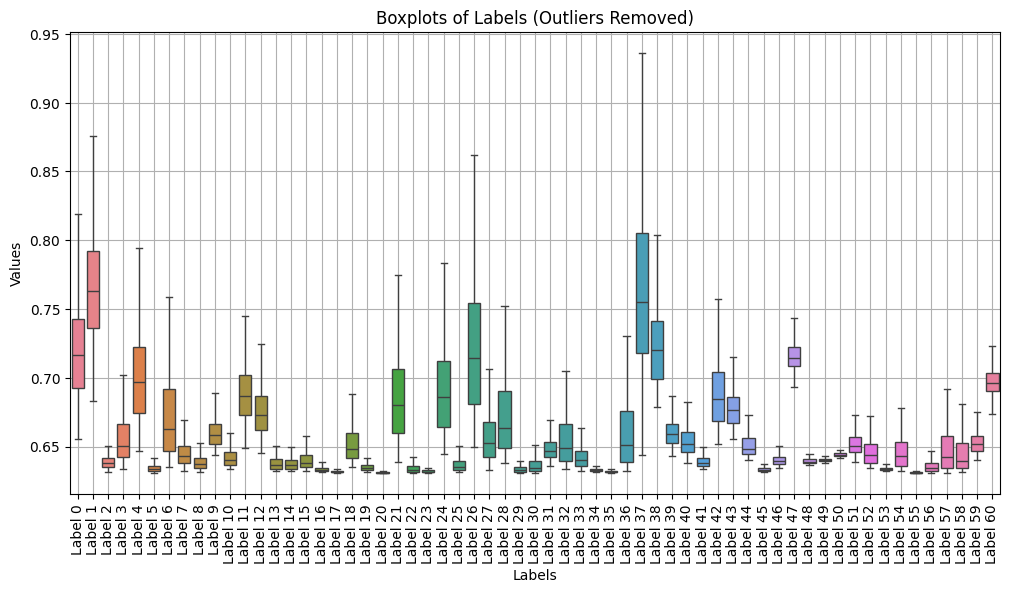

In [4]:
visualize_label_distributions(loader, 61)

# Clustering of Grad-CAM

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from kmeans_pytorch import kmeans
from pytorch_grad_cam import GradCAM
import torch.nn as nn
import torch.backends.cudnn as cudnn
import yaml
import torch.nn.functional as F
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, MyMultiOutputTarget
from sklearn.cluster import KMeans
import sys
sys.path.append('../')  # Adjust the path to point to the directory containing data_loader.py
# ========================
#  Define a custom target for GradCAM
# ========================
def load_yaml_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
config = load_yaml_config('../config/config.yaml')
# Temporarily disable cuDNN for RNNs
cudnn_enabled = cudnn.enabled  # save current setting
cudnn.enabled = False

# ========================
#  Set random seeds for reproducibility
# ========================
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ========================
#  Assume model and GradCAMWrapper are defined and checkpoint is loaded
# ========================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.dropout_cnn = nn.Dropout(0.1)
        
        # Compute CNN output dimensions based on your input size.
        # Here, these values are placeholders – adjust them to match your data.
        cnn_output_height = 1849 // 8  
        cnn_output_width = 1458 // 8
        cnn_output_channels = 64
        cnn_output_size = cnn_output_channels * cnn_output_height * cnn_output_width
        
        # LSTM layers
        self.lstm = nn.LSTM(167040, 512, num_layers=2, batch_first=True, dropout=0.1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 61)
        
        # Initialize biases
        nn.init.constant_(self.fc1.bias, 0.1)
        nn.init.constant_(self.fc2.bias, 0.1)
        nn.init.constant_(self.fc3.bias, 0.1)
        
        self.relu = nn.ReLU()

    def forward(self, ppt, tmin, tmax):
        # Concatenate inputs along the channel dimension
        x = torch.cat((ppt.unsqueeze(2), tmin.unsqueeze(2), tmax.unsqueeze(2)), dim=2)
        batch_size, seq_len, _, height, width = x.shape
        
        # Process each timestep independently through the CNN
        cnn_features = []
        for t in range(seq_len):
            x_t = x[:, t]  # [batch_size, 3, height, width]
            x_t = self.pool(self.batch_norm1(F.relu(self.conv1(x_t))))
            x_t = self.pool(self.batch_norm2(F.relu(self.conv2(x_t))))
            x_t = self.pool(self.batch_norm3(F.relu(self.conv3(x_t))))
            x_t = x_t.view(batch_size, -1)  # Flatten for LSTM input
            cnn_features.append(x_t)
        
        # Stack features along the time dimension
        x = torch.stack(cnn_features, dim=1)  # [batch_size, seq_len, cnn_output_size]
        
        # Process with LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Use last time step
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

class GradCAMWrapper(nn.Module):
    def __init__(self, model):
        super(GradCAMWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # x shape: [B, 3, 5, H, W]
        # Extract each modality along the channel dimension.
        ppt = x[0, :, :, :]   # shape: [B, 5, H, W]
        tmin = x[1, :, :, :]  # shape: [B, 5, H, W]
        tmax = x[2, :, :, :]  # shape: [B, 5, H, W]
        # If your model expects a channel dimension for each modality, add it.
        # This converts the shape to [B, 5, 1, H, W].
        ppt = ppt.unsqueeze(0)
        tmin = tmin.unsqueeze(0)
        tmax = tmax.unsqueeze(0)
        return self.model(ppt, tmin, tmax)


# Create model instance and move to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
# Define the path to your checkpoint file
checkpoint_path = '/home/talhamuh/water-research/CNN-LSMT/src/cnn_lstm_project/checkpoint/finetune_cnn_lstm_global_temporal_extrapolation_61_10y'

# Load the checkpoint using torch.load
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the state dictionary into your model
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
# model.eval()

print("Pretrained checkpoint loaded successfully!")
    

from data_loader import HDF5Dataset
variables_to_load = ['ppt', 'tmin', 'tmax']
dataset = HDF5Dataset(config['h5_file'], variables_to_load, config['labels_path'], 2000, 2009)  
dataset_size = len(dataset)    
num_train = int(0.8 * len(dataset))
num_val = int(0.1 * len(dataset))
num_test = len(dataset) - num_train - num_val

# Indices:
train_indices = range(0, num_train)
val_indices   = range(num_train, num_train + num_val)
test_indices  = range(num_train + num_val, dataset_size)
# Randomly split the dataset
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])
# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset   = Subset(dataset, val_indices)
test_dataset  = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=32)

# test_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=32)
print("data has been loaded ...")

# Wrap the model
wrapped_model = GradCAMWrapper(model).to(device)
wrapped_model.eval()
# ========================
#  Initialize GradCAM
# ========================
# Choose a target convolutional layer. For instance, if using conv3:
cam_target_layer = model.conv3  # adjust if needed
cam = GradCAM(model=wrapped_model, target_layers=[cam_target_layer])

# ========================
#  Run inference over the test set and collect Grad-CAM heatmaps in memory.
#  We will compute one heatmap per sample for each of the 61 output locations.
# ========================
# Create a dictionary to hold heatmaps per location.
num_locations = 61
location_heatmap_dict = {loc: [] for loc in range(num_locations)}

Pretrained checkpoint loaded successfully!
data has been loaded ...


In [2]:
print("Running inference and collecting Grad-CAM heatmaps...")
for batch_idx, batch in enumerate(test_loader):
    # Each batch is assumed to have keys: 'ppt', 'tmin', 'tmax', 'label'
    # and shape: [B, seq_len, H, W]. (For simplicity we assume B=1.)
    ppt  = batch['ppt'].to(device)   # shape: [B, seq_len, H, W]
    tmin = batch['tmin'].to(device)
    tmax = batch['tmax'].to(device)
    # Stack modalities to form an input of shape [B, 3, seq_len, H, W]
    day_input = torch.stack([ppt, tmin, tmax], dim=1)  

    # Loop over each sample in the batch
    for i in range(day_input.shape[0]):
        sample_input = day_input[i]  # shape: [3, seq_len, H, W]
        # For each location (target index from 0 to 60) compute Grad-CAM.
        # (This loop means that for each sample we run Grad-CAM 61 times.
        #  If this is too slow, consider processing one target per run or another strategy.)
        for loc in range(num_locations):
            # Create the target for GradCAM (your custom target should accept a location index)
            target = MyMultiOutputTarget(loc)
            # Compute GradCAM; output shape is assumed to be [H, W] for each target.
            grayscale_cam = cam(input_tensor=sample_input, targets=[target])
            cam_image = grayscale_cam[0, :]  # [H, W]
            # Convert to numpy and store (make a copy to avoid later modifications)
            heatmap_np = cam_image.copy()
            location_heatmap_dict[loc].append(heatmap_np)

            # Clean up per target (optional)
            del target, grayscale_cam, cam_image
            torch.cuda.empty_cache()

    # Clean up batch variables
    del ppt, tmin, tmax, day_input, batch
    torch.cuda.empty_cache()
    print(f"Processed batch {batch_idx}")

print("Finished collecting Grad-CAM heatmaps.")

Running inference and collecting Grad-CAM heatmaps...


Processed batch 0
Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed batch 20
Processed batch 21
Processed batch 22
Processed batch 23
Processed batch 24
Processed batch 25
Processed batch 26
Processed batch 27
Processed batch 28
Processed batch 29
Processed batch 30
Processed batch 31
Processed batch 32
Processed batch 33
Processed batch 34
Processed batch 35
Processed batch 36
Processed batch 37
Processed batch 38
Processed batch 39
Processed batch 40
Processed batch 41
Processed batch 42
Processed batch 43
Processed batch 44
Processed batch 45
Processed batch 46
Processed batch 47
Processed batch 48
Processed batch 49
Processed batch 50
Processed batch 51
Processed batch 52
Pro

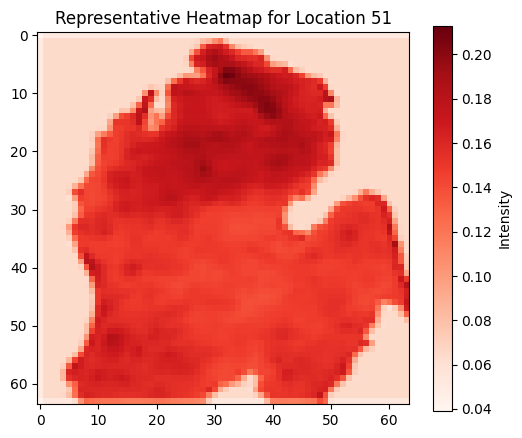

Location features shape: (61, 4096)


In [3]:
# ========================
#  Aggregate heatmaps per location into a feature vector.
#  For example, we compute the temporal average and then downsample the result.
# ========================
def aggregate_heatmaps(heatmap_list, downsample_size=(64, 64)):
    """
    Given a list of heatmaps (each of shape [H, W]), compute the temporal average,
    then downsample to a specified resolution, and flatten to a feature vector.
    """
    heatmaps_stack = np.stack(heatmap_list, axis=0)  # shape: (num_samples, H, W)
    avg_heatmap = np.mean(heatmaps_stack, axis=0)      # shape: (H, W)
    # Downsample using OpenCV (adjust interpolation if needed)
    avg_heatmap_down = cv2.resize(avg_heatmap, downsample_size, interpolation=cv2.INTER_AREA)
    feature_vector = avg_heatmap_down.flatten()        # shape: (downsample_size[0]*downsample_size[1],)
    return feature_vector, avg_heatmap_down

location_features = []
for loc in range(num_locations):
    feat, rep_map = aggregate_heatmaps(location_heatmap_dict[loc], downsample_size=(64, 64))
    location_features.append(feat)
    # Optionally visualize the representative map for one location:
    if loc == 51:
        plt.figure(figsize=(6, 5))
        plt.imshow(rep_map, cmap='Reds')
        plt.title(f"Representative Heatmap for Location {loc}")
        plt.colorbar(label="Intensity")
        plt.show()

location_features = np.stack(location_features, axis=0)  # shape: (61, 64*64)
print("Location features shape:", location_features.shape)

In [4]:
# Save the array to a file called 'my_array.npy'
np.save('my_array.npy', location_features)

# Later, load the array back from the file
loaded_array = np.load('my_array.npy')

# Verify that the saved and loaded arrays are the same
print(np.array_equal(location_features, loaded_array))  # This should print True

True


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
location_features = scaler.fit_transform(location_features)


In [12]:
# ========================
#  Set random seeds for reproducibility
# ========================
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ========================
#  Cluster the location feature vectors.
# ========================

n_clusters = 4  # or set according to your domain knowledge
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
location_labels = kmeans.fit_predict(location_features)

print("Cluster assignments for each location:")
for loc, label in enumerate(location_labels):
    print(f"Location {loc}: Cluster {label}")


Cluster assignments for each location:
Location 0: Cluster 2
Location 1: Cluster 2
Location 2: Cluster 2
Location 3: Cluster 2
Location 4: Cluster 2
Location 5: Cluster 2
Location 6: Cluster 2
Location 7: Cluster 0
Location 8: Cluster 2
Location 9: Cluster 2
Location 10: Cluster 0
Location 11: Cluster 2
Location 12: Cluster 2
Location 13: Cluster 2
Location 14: Cluster 2
Location 15: Cluster 0
Location 16: Cluster 2
Location 17: Cluster 0
Location 18: Cluster 2
Location 19: Cluster 0
Location 20: Cluster 3
Location 21: Cluster 2
Location 22: Cluster 0
Location 23: Cluster 2
Location 24: Cluster 2
Location 25: Cluster 3
Location 26: Cluster 2
Location 27: Cluster 2
Location 28: Cluster 3
Location 29: Cluster 3
Location 30: Cluster 3
Location 31: Cluster 1
Location 32: Cluster 2
Location 33: Cluster 3
Location 34: Cluster 1
Location 35: Cluster 0
Location 36: Cluster 0
Location 37: Cluster 3
Location 38: Cluster 1
Location 39: Cluster 1
Location 40: Cluster 1
Location 41: Cluster 1
Locat

In [13]:
import numpy as np
import pandas as pd

# List of site numbers corresponding to your locations 0 through 60
site_numbers = [
    4099000, 4101500, 4097540, 4176000, 4097500, 4096515, 4176500, 4096405,
    4175600, 4102500, 4109000, 4106000, 4105500, 4167000, 4102700, 4166500,
    4104945, 4163400, 4117500, 4108600, 4112000, 4113000, 4108800, 4164100,
    4114000, 4160600, 4116000, 4144500, 4148500, 4146000, 4159900, 4118500,
    4147500, 4146063, 4115265, 4122100, 4151500, 4157005, 4121970, 4122200,
    4154000, 4152238, 4121500, 4122500, 4142000, 4124500, 4121300, 4125550,
    4126970, 4126740, 4127800, 4101800, 4105000, 4105700, 4112500, 4164300,
    4148140, 4115000, 4159492, 4121944, 4124200
]

# Check that we have 61 site numbers:
assert len(site_numbers) == 61, "Expected 61 site numbers."

In [14]:
# Now create a mapping: Site Number -> Cluster
site_cluster_map = {site: cluster for site, cluster in zip(site_numbers, location_labels)}

# Option 1: Print out the mapping as text.
print("Site Number -> Cluster Mapping:")
for site, cluster in site_cluster_map.items():
    print(f"Site {site}: Cluster {cluster}")

# Option 2: Create a DataFrame for a neat table.
df = pd.DataFrame({
    'Site Number': site_numbers,
    'Cluster': location_labels
})
print("\nMapping in tabular form:")
df

Site Number -> Cluster Mapping:
Site 4099000: Cluster 2
Site 4101500: Cluster 2
Site 4097540: Cluster 2
Site 4176000: Cluster 2
Site 4097500: Cluster 2
Site 4096515: Cluster 2
Site 4176500: Cluster 2
Site 4096405: Cluster 0
Site 4175600: Cluster 2
Site 4102500: Cluster 2
Site 4109000: Cluster 0
Site 4106000: Cluster 2
Site 4105500: Cluster 2
Site 4167000: Cluster 2
Site 4102700: Cluster 2
Site 4166500: Cluster 0
Site 4104945: Cluster 2
Site 4163400: Cluster 0
Site 4117500: Cluster 2
Site 4108600: Cluster 0
Site 4112000: Cluster 3
Site 4113000: Cluster 2
Site 4108800: Cluster 0
Site 4164100: Cluster 2
Site 4114000: Cluster 2
Site 4160600: Cluster 3
Site 4116000: Cluster 2
Site 4144500: Cluster 2
Site 4148500: Cluster 3
Site 4146000: Cluster 3
Site 4159900: Cluster 3
Site 4118500: Cluster 1
Site 4147500: Cluster 2
Site 4146063: Cluster 3
Site 4115265: Cluster 1
Site 4122100: Cluster 0
Site 4151500: Cluster 0
Site 4157005: Cluster 3
Site 4121970: Cluster 1
Site 4122200: Cluster 1
Site 415

,Site Number,Cluster
0,4099000,2
1,4101500,2
2,4097540,2
3,4176000,2
4,4097500,2
...,...,...
56,4148140,3
57,4115000,1
58,4159492,0
59,4121944,1


In [15]:
usgs_path = "/home/talhamuh/water-research/CNN-LSMT/data/processed/streamflow_data/usgs_locations.csv"
df_latlon = pd.read_csv(usgs_path)


# 4) Convert site_no to integer by removing leading zeros
df_latlon["site_no_int"] = df_latlon["site_no"].apply(lambda x: int(str(x).lstrip("0")))

# 5) Merge with your cluster DataFrame on "Site Number" and "site_no_int"
df_merged = df.merge(
    df_latlon,
    left_on="Site Number",     # from your cluster DataFrame
    right_on="site_no_int",    # from df_latlon
    how="inner"
)


# 6) Rename or drop columns as desired
df_merged.rename(columns={
    "Site Number": "site_number",
    "dec_lat_va": "latitude",
    "dec_long_v": "longitude",
    "Cluster": "cluster"
}, inplace=True)

df_merged.drop(columns=["site_no_int", "site_no"], inplace=True)

In [16]:
final_df = df_merged[["site_number", "cluster", "longitude", "latitude"]].copy()
final_df

,site_number,cluster,longitude,latitude
0,4099000,2,-85.756105,41.800883
1,4101500,2,-86.259732,41.829214
2,4097540,2,-85.409428,41.888383
3,4176000,2,-83.980776,41.904769
4,4097500,2,-85.632771,41.940326
...,...,...,...,...
56,4148140,3,-83.581342,43.033638
57,4115000,1,-84.693052,43.109755
58,4159492,0,-82.624647,43.150860
59,4121944,1,-85.595599,43.430858


Min Longitude: -86.54262785928825
Min Latitude: 41.71144825223513
Max Longitude: -82.4198362733253
Max Latitude: 45.780304369950784


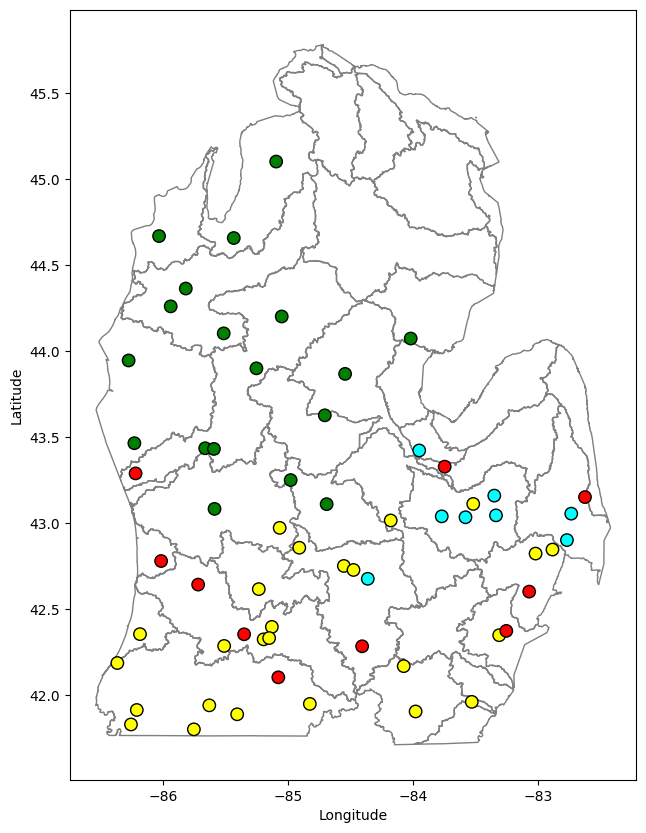

In [22]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
# --- Step 2: Convert your DataFrame into a GeoDataFrame ---
# Create a geometry column from longitude and latitude.
geometry = gpd.points_from_xy(final_df['longitude'], final_df['latitude'])
gdf_points = gpd.GeoDataFrame(final_df, geometry=geometry, crs="EPSG:4326")
# If your shapefile is in another CRS, you might need to reproject one of them.

# --- Step 3: Load the shapefile ---
shp_path = "/home/talhamuh/water-research/CNN-LSMT/data/raw/Michigan/Final_Michigan_Map/Watershed_Boundary_Intersect_Michigan.shp"
gdf_map = gpd.read_file(shp_path)

# Optional: if the shapefile's CRS is different from EPSG:4326, convert it:
if gdf_map.crs != "EPSG:4326":
    gdf_map = gdf_map.to_crs("EPSG:4326")

# Get the bounding box: [min_long, min_lat, max_long, max_lat]
min_long, min_lat, max_long, max_lat = gdf_map.total_bounds

print("Min Longitude:", min_long)
print("Min Latitude:", min_lat)
print("Max Longitude:", max_long)
print("Max Latitude:", max_lat)


# --- Step 4: Plot the base map and overlay the points ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile as the base map (adjust color as needed)
gdf_map.plot(ax=ax, color="none", edgecolor="gray")

# You can choose any 5 distinct colors. Here is an example:
custom_cmap = ListedColormap(['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink', 'cyan'])       
# Plot the USGS points colored by cluster.
# Use a categorical colormap (here 'tab10' works for up to 10 clusters)
gdf_points.plot(ax=ax, column='cluster', cmap=custom_cmap, markersize=80, edgecolor='k', legend=False)

# Set background to transparent
ax.set_facecolor('none')  # Make the plot background transparent
fig.patch.set_alpha(0)  # Make the figure background transparent
# Remove axis lines, ticks, and labels
# ax.set_axis_off()  # Removes the axis
# ax.set_color
# ax.set_title("USGS Site Locations on Michigan Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [18]:
output_path = "/home/talhamuh/water-research/CNN-LSMT/src/cnn_lstm_project/data_plots/clusters_points/4_gdf_points.geojson"
gdf_points.to_file(output_path, driver="GeoJSON")
print(f"GeoDataFrame saved to {output_path}")

GeoDataFrame saved to /home/talhamuh/water-research/CNN-LSMT/src/cnn_lstm_project/data_plots/clusters_points/4_gdf_points.geojson


# Clustering of ground truths

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Load the CSV data
csv_path = "/home/talhamuh/water-research/CNN-LSMT/data/processed/streamflow_data/spatial_interpolation.csv"
df = pd.read_csv(csv_path, parse_dates=["date"])
df.set_index("date", inplace=True)

# 2. Specify the start and end year for filtering the data
start_year = 2000
end_year = 2009

# Filter the DataFrame to include only rows within the specified years
df = df.loc[(df.index.year >= start_year) & (df.index.year <= end_year)]
print(f"Data shape after filtering for years {start_year} to {end_year}: {df.shape}")


df

Data shape after filtering for years 2000 to 2009: (3650, 61)


,4099000,4101500,4097540,4176000,4097500,4096515,4176500,4096405,4175600,4102500,...,4101800,4105000,4105700,4112500,4164300,4148140,4115000,4159492,4121944,4124200
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,819,1990,47.0,140.0,527,9.8,195.0,72.0,43.0,270,...,202.0,69.0,28.0,43.0,0.40,25.0,34.0,32.0,200,1090
2000-01-02,832,1960,49.0,149.0,533,10.0,198.0,71.0,44.0,273,...,218.0,82.0,32.0,45.0,0.53,27.0,34.0,35.0,206,1120
2000-01-03,877,2070,52.0,169.0,539,11.0,210.0,78.0,58.0,302,...,254.0,93.0,37.0,54.0,0.72,28.0,35.0,39.0,240,1120
2000-01-04,855,2040,56.0,195.0,558,12.0,219.0,89.0,77.0,314,...,254.0,100.0,37.0,65.0,1.00,30.0,36.0,51.0,251,1180
2000-01-05,852,2100,56.0,196.0,560,11.0,230.0,89.0,72.0,325,...,252.0,99.0,35.0,63.0,0.86,22.0,37.0,66.0,235,1090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,2050,5420,161.0,1170.0,1480,88.0,1220.0,239.0,188.0,696,...,564.0,262.0,65.0,345.0,27.50,84.1,249.0,255.0,393,1330
2009-12-28,2160,5000,164.0,1120.0,1610,95.0,1510.0,235.0,171.0,665,...,492.0,272.0,56.4,323.0,13.90,85.7,275.0,181.0,370,1300
2009-12-29,2200,4780,157.0,723.0,1630,91.0,1430.0,239.0,157.0,630,...,451.0,300.0,49.7,264.0,7.20,79.6,283.0,131.0,343,1250


In [53]:
# 2. Standardize the data for each location (each column)
# This will remove scale differences across locations.
scaler = StandardScaler()
data_std = scaler.fit_transform(df)  # Shape: (n_days, n_locations)

# 3. Transpose the standardized data so that each row corresponds to a location's time series
X = data_std.T  # Now shape is: (n_locations, n_days)

# 4. Cluster the locations using KMeans
num_clusters = 4  # You can change this number based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Create a DataFrame to display cluster assignments for each location
cluster_df = pd.DataFrame({
    "Site Number": df.columns,
    "Cluster": clusters
})
cluster_df



,Site Number,Cluster
0,4099000,2
1,4101500,2
2,4097540,2
3,4176000,2
4,4097500,2
...,...,...
56,4148140,3
57,4115000,3
58,4159492,3
59,4121944,1


In [54]:
usgs_path = "/home/talhamuh/water-research/CNN-LSMT/data/processed/streamflow_data/usgs_locations.csv"
df_latlon = pd.read_csv(usgs_path)


# 4) Convert site_no to integer by removing leading zeros
df_latlon["site_no_int"] = df_latlon["site_no"].apply(lambda x: int(str(x).lstrip("0")))
cluster_df["Site Number"] = cluster_df["Site Number"].astype(int)
# 5) Merge with your cluster DataFrame on "Site Number" and "site_no_int"
df_merged = cluster_df.merge(
    df_latlon,
    left_on="Site Number",     # from your cluster DataFrame
    right_on="site_no_int",    # from df_latlon
    how="inner"
)


# 6) Rename or drop columns as desired
df_merged.rename(columns={
    "Site Number": "site_number",
    "dec_lat_va": "latitude",
    "dec_long_v": "longitude",
    "Cluster": "cluster"
}, inplace=True)

df_merged.drop(columns=["site_no_int", "site_no"], inplace=True)

In [55]:
final_df = df_merged[["site_number", "cluster", "longitude", "latitude"]].copy()
final_df

,site_number,cluster,longitude,latitude
0,4099000,2,-85.756105,41.800883
1,4101500,2,-86.259732,41.829214
2,4097540,2,-85.409428,41.888383
3,4176000,2,-83.980776,41.904769
4,4097500,2,-85.632771,41.940326
...,...,...,...,...
56,4148140,3,-83.581342,43.033638
57,4115000,3,-84.693052,43.109755
58,4159492,3,-82.624647,43.150860
59,4121944,1,-85.595599,43.430858


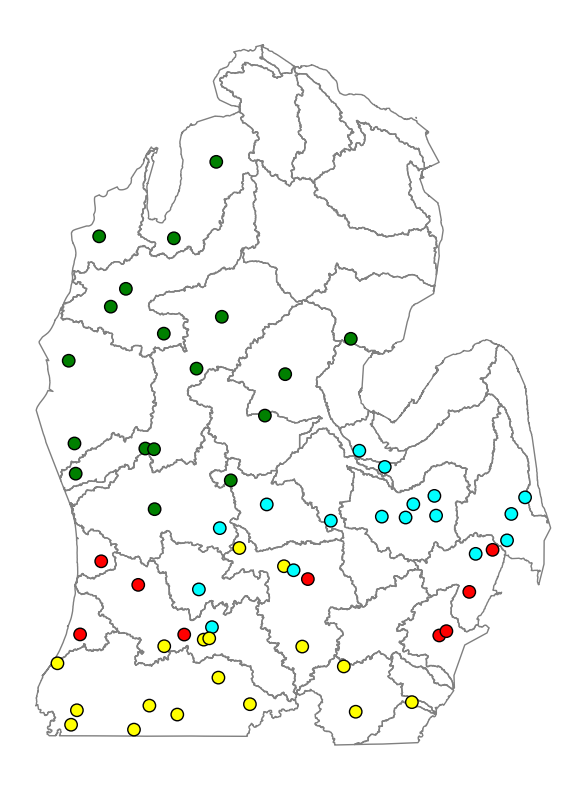

In [56]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
# --- Step 2: Convert your DataFrame into a GeoDataFrame ---
# Create a geometry column from longitude and latitude.
geometry = gpd.points_from_xy(final_df['longitude'], final_df['latitude'])
gdf_points = gpd.GeoDataFrame(final_df, geometry=geometry, crs="EPSG:4326")
# If your shapefile is in another CRS, you might need to reproject one of them.

# --- Step 3: Load the shapefile ---
shp_path = "/home/talhamuh/water-research/CNN-LSMT/data/raw/Michigan/Final_Michigan_Map/Watershed_Boundary_Intersect_Michigan.shp"
gdf_map = gpd.read_file(shp_path)

# Optional: if the shapefile's CRS is different from EPSG:4326, convert it:
if gdf_map.crs != "EPSG:4326":
    gdf_map = gdf_map.to_crs("EPSG:4326")

# --- Step 4: Plot the base map and overlay the points ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile as the base map (adjust color as needed)
gdf_map.plot(ax=ax, color="none", edgecolor="gray")

# You can choose any 5 distinct colors. Here is an example:
custom_cmap = ListedColormap(['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink', 'cyan'])       
# Plot the USGS points colored by cluster.
# Use a categorical colormap (here 'tab10' works for up to 10 clusters)
gdf_points.plot(ax=ax, column='cluster', cmap=custom_cmap, markersize=80, edgecolor='k', legend=False)

# Set background to transparent
ax.set_facecolor('none')  # Make the plot background transparent
fig.patch.set_alpha(0)  # Make the figure background transparent
# Remove axis lines, ticks, and labels
ax.set_axis_off()  # Removes the axis
# ax.set_color
# ax.set_title("USGS Site Locations on Michigan Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()